In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from scipy import signal
from sklearn import decomposition
from sklearn.cluster import DBSCAN

from population import unit_response_matrix, activity_at_phase

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [21]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
#source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = [s for s in selected_009266.keys()]
#sessions = [s for s in selected_009265.keys()]
#sessions = [s for s in selected_008229.keys()]
sessions.sort()

selected = sessions[:]
selected

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

/tmp/ipykernel_239506/1316665318.py:8: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  kernel = signal.gaussian(width, std=(width) / 7.2)


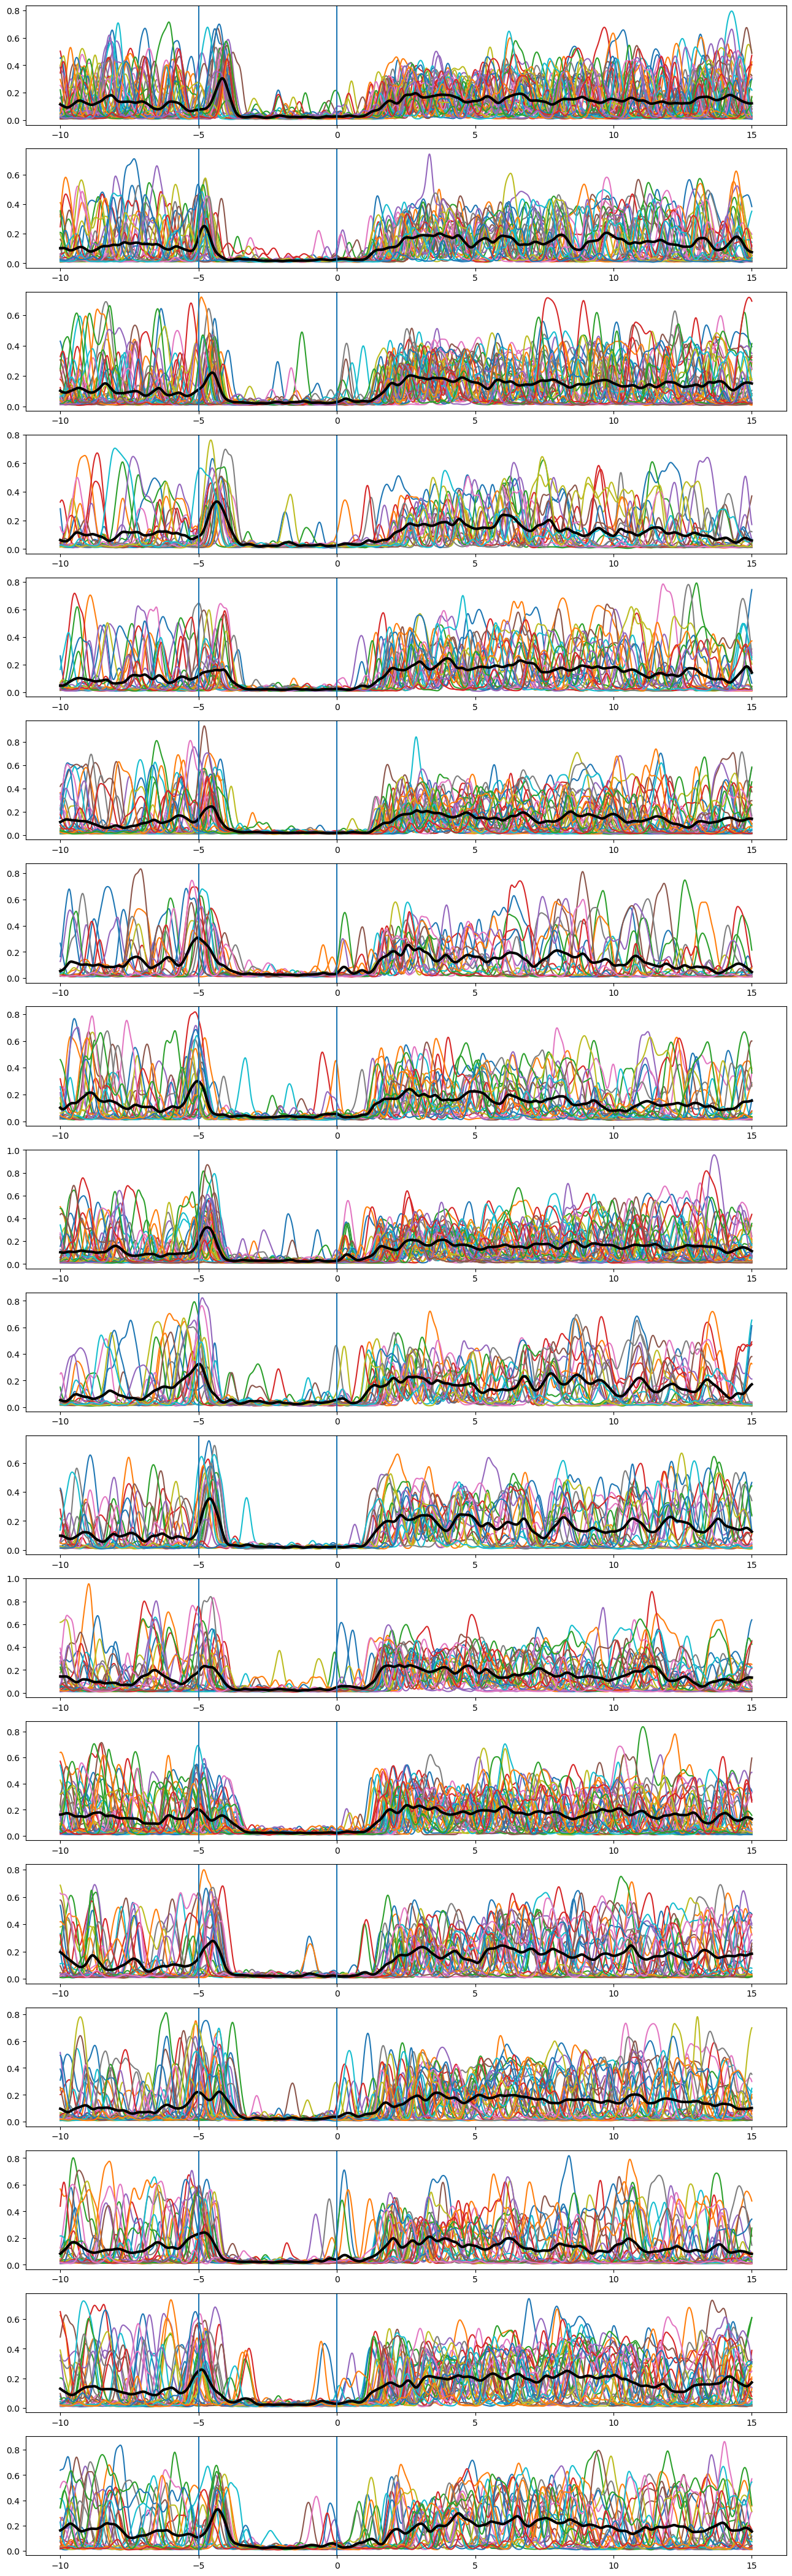

In [24]:
rows = len(selected)
cols = 1
size = 3
s_rate = 100  # timeline sampling Hz 
t_l, t_r = -10, 15
x_vals = np.linspace(t_l, t_r, (t_r - t_l)*s_rate)
width = 70  # 100 points ~= 1 sec with at 100Hz
kernel = signal.gaussian(width, std=(width) / 7.2)

fig, axes = plt.subplots(rows, cols, figsize=(16*cols, size*rows))

for i, session in enumerate(selected):
    animal = session.split('_')[0]
    meta_file  = os.path.join(source, animal, session, 'meta.h5')
    moseq_file = os.path.join(source, animal, session, 'MoSeq.h5')
    
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(moseq_file, 'r') as f:
        moseq = np.array(f['moseq'])
        headers = f['moseq'].attrs['headers']
        
    dx = np.sqrt(np.square(np.diff(moseq[:, 3])) + np.square(np.diff(moseq[:, 4])))
    dt = np.diff(moseq[:, 0])
    speed = np.concatenate([dx/dt, [dx[-1]/dt[-1]]])
    speed_smooth = np.convolve(speed, kernel, 'same') / kernel.sum()

    ax = axes[i]
    tgt_success_mx = tgt_mx[tgt_mx[:, 4] == 1]
    avgs = np.zeros([len(tgt_success_mx), len(x_vals)])
    for j, tgt_rec in enumerate(tgt_success_mx):
        speed_profile = speed_smooth[tgt_rec[3] + t_l*s_rate:tgt_rec[3] + t_r*s_rate]
        avgs[j] = speed_profile
        ax.plot(x_vals, speed_profile)

    ax.plot(x_vals, avgs.mean(axis=0), lw=3, color='black')
    ax.axvline(0)
    ax.axvline(-5)

In [13]:
moseq.shape, headers

((239997, 41),
 array(['time', 'syllables reindexed', 'syllables non-reindexed',
        'centroid x', 'centroid y', 'heading', 'estimated bodypart0 x',
        'estimated bodypart0 y', 'estimated bodypart1 x',
        'estimated bodypart1 y', 'estimated bodypart2 x',
        'estimated bodypart2 y', 'estimated bodypart3 x',
        'estimated bodypart3 y', 'estimated bodypart4 x',
        'estimated bodypart4 y', 'estimated bodypart5 x',
        'estimated bodypart5 y', 'estimated bodypart6 x',
        'estimated bodypart6 y', 'estimated bodypart7 x',
        'estimated bodypart7 y', 'estimated bodypart8 x',
        'estimated bodypart8 y', 'estimated bodypart9 x',
        'estimated bodypart9 y', 'estimated bodypart10 x',
        'estimated bodypart10 y', 'estimated bodypart11 x',
        'estimated bodypart11 y', 'estimated bodypart12 x',
        'estimated bodypart12 y', 'latent_state 0', 'latent_state 1',
        'latent_state 2', 'latent_state 3', 'latent_state 4',
        'laten

In [14]:
dx = np.sqrt(np.square(np.diff(moseq[:, 3])) + np.square(np.diff(moseq[:, 4])))
dt = np.diff(moseq[:, 0])
speed = np.concatenate([dx/dt, [dx[-1]/dt[-1]]])
speed.shape

(239997,)